# Terrain Preprocessing - Kevin's Manual Data
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_manual/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Synthesis' not in path or 'Kevin' not in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Synthesis_GrassStraightKevin_Module',
 'Synthesis_GravelDonutKevin_Module',
 'Synthesis_CarpetDonutKevin_Module',
 'Synthesis_GravelStraightKevin_Module',
 'Synthesis_LinoleumStraightKevin_Module',
 'Synthesis_SidewalkDonutKevin_Module',
 'Synthesis_GrassDonutKevin_Module',
 'Synthesis_ConcreteStraightKevin_Module',
 'Synthesis_AsphaltStraightKevin_Module',
 'Synthesis_ConcreteF8Kevin_Module',
 'Synthesis_GrassF8Kevin_Module',
 'Synthesis_SidewalkStraightKevin_Module',
 'Synthesis_GravelF8Kevin_Module',
 'Synthesis_SidewalkF8Kevin_Module',
 'Synthesis_LinoleumF8Kevin_Module',
 'Synthesis_AsphaltDonutKevin_Module',
 'Synthesis_AsphaltF8Kevin_Module',
 'Synthesis_ConcreteDonutKevin_Module',
 'Synthesis_CarpetF8Kevin_Module',
 'Synthesis_LinoleumDonutKevin_Module',
 'Synthesis_CarpetStraightKevin_Module']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
2094,2.762788,0.096022,0.021075,9.265733,2.927464,0.321559,9.717194,0.007240,-0.001839,0.306924,5.826299,-8.309812,1.059634,9.992839,0.020636,-0.030866,-0.327828,6.283,1.564596e+09
2095,0.445189,0.097358,0.024097,9.276507,2.893945,0.089325,9.717433,-0.006076,-0.004769,0.308789,5.820314,-8.139826,1.051255,9.956550,0.021702,-0.036459,-0.333154,6.286,1.564596e+09
2096,0.772533,0.099675,0.023946,9.353120,2.795784,-0.126150,9.762032,0.005909,-0.003437,0.316778,5.710182,-8.188907,0.997386,10.062487,0.019837,-0.042584,-0.339280,6.289,1.564596e+09
2097,0.785627,0.102032,0.026363,9.411777,2.950208,0.064187,9.863330,0.011768,-0.005301,0.322637,5.687438,-8.216439,1.024919,10.151532,0.027827,-0.040454,-0.344073,6.292,1.564596e+09
2098,0.484470,0.103486,0.027723,9.420157,2.883171,0.037851,9.851499,0.006974,-0.013024,0.326365,5.776022,-8.109899,0.987809,10.093655,0.031023,-0.043383,-0.351264,6.295,1.564596e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

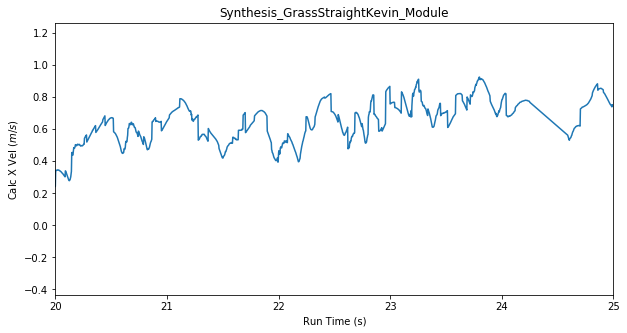

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Calc X Vel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

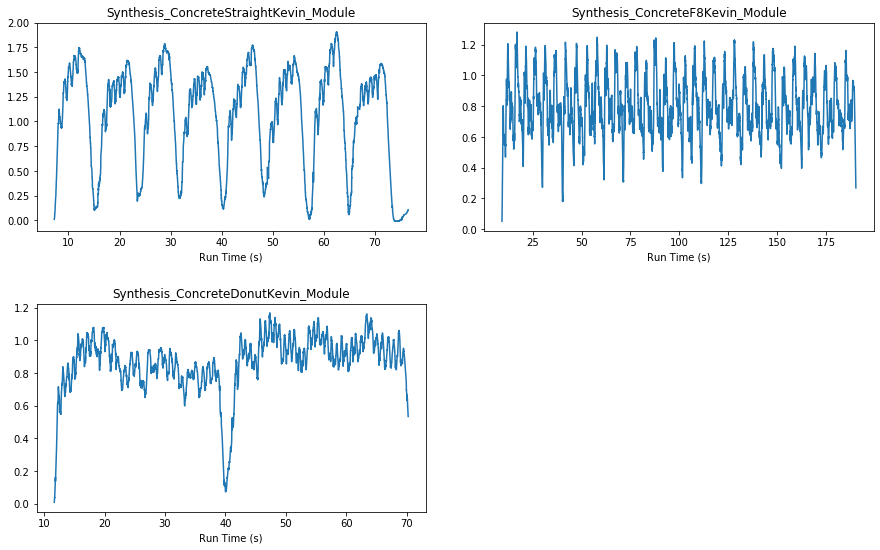

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Synthesis' in label and 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Calc X Vel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 21
Shape of first dataset: (28804, 19)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

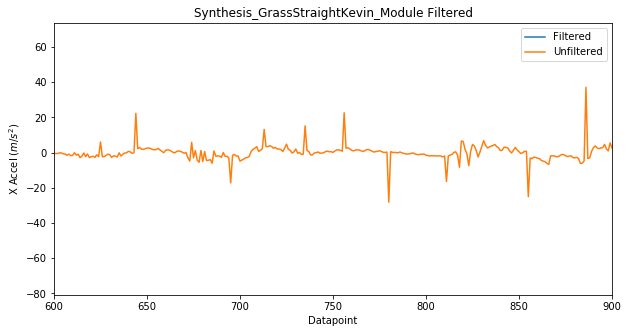

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 21
Shape of first filtered dataset: (28804, 19)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
0,NaN,0.096023,0.021075,9.265801,2.927427,0.321629,9.717246,0.007245,-0.001842,0.306928,5.826348,-8.309841,1.059607,9.992743,0.020639,-0.030863,-0.327831,6.283,1.564596e+09
1,NaN,0.097788,0.023082,9.303688,2.896135,0.101651,9.744102,0.004774,-0.003336,0.311141,5.755128,-8.227795,1.040133,10.021343,0.021481,-0.036119,-0.333072,6.286,1.564596e+09
2,NaN,0.099656,0.024837,9.348150,2.875426,-0.016954,9.780496,0.004353,-0.005372,0.315926,5.719399,-8.169256,1.014761,10.056950,0.023317,-0.040155,-0.338538,6.289,1.564596e+09
3,NaN,0.101621,0.026227,9.394644,2.861508,-0.017301,9.821016,0.005533,-0.007480,0.321362,5.739375,-8.142542,0.991677,10.093050,0.025829,-0.042736,-0.344615,6.292,1.564596e+09
4,NaN,0.103586,0.027296,9.427823,2.843108,0.033188,9.847579,0.006486,-0.008444,0.327081,5.804438,-8.143024,0.992170,10.114788,0.027699,-0.044398,-0.351631,6.295,1.564596e+09


<Figure size 432x288 with 0 Axes>

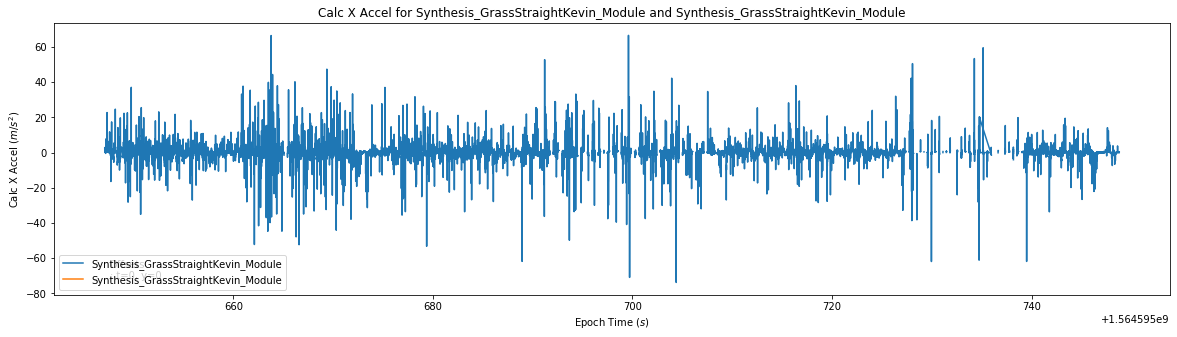

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'Calc X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [31]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

'\nfor terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.up

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 21
Num of windows in first dataset: 86
Shape of individual window: (333, 19)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
328,NaN,0.635043,-0.138304,0.557298,-9.703997,-1.303609,9.724815,-0.011136,0.066218,2.274584,7.803772,6.760167,0.038657,10.409230,0.059927,-0.126151,-2.071753,7.268,1.564596e+09
329,NaN,0.637981,-0.134081,-0.146258,-9.554629,-1.107163,9.543295,-0.001072,0.068902,2.280820,7.475808,7.250544,0.983873,10.428793,0.067005,-0.123964,-2.082793,7.271,1.564596e+09
330,NaN,0.640395,-0.127231,-0.701941,-9.404901,-1.055834,9.418222,0.010634,0.058508,2.282967,7.161813,7.708524,1.311421,10.344784,0.056158,-0.128118,-2.091878,7.274,1.564596e+09
331,NaN,0.642052,-0.118789,-1.113816,-9.352218,-1.051790,9.417210,0.016866,0.035029,2.281144,6.883748,7.990959,0.762450,10.330786,0.033023,-0.138038,-2.099241,7.277,1.564596e+09
332,NaN,0.643124,-0.110446,-1.388067,-9.424102,-0.895212,9.531562,0.013578,0.004077,2.277424,6.688892,8.089125,-0.112795,10.421091,0.009181,-0.151323,-2.104615,7.280,1.564596e+09


<Figure size 432x288 with 0 Axes>

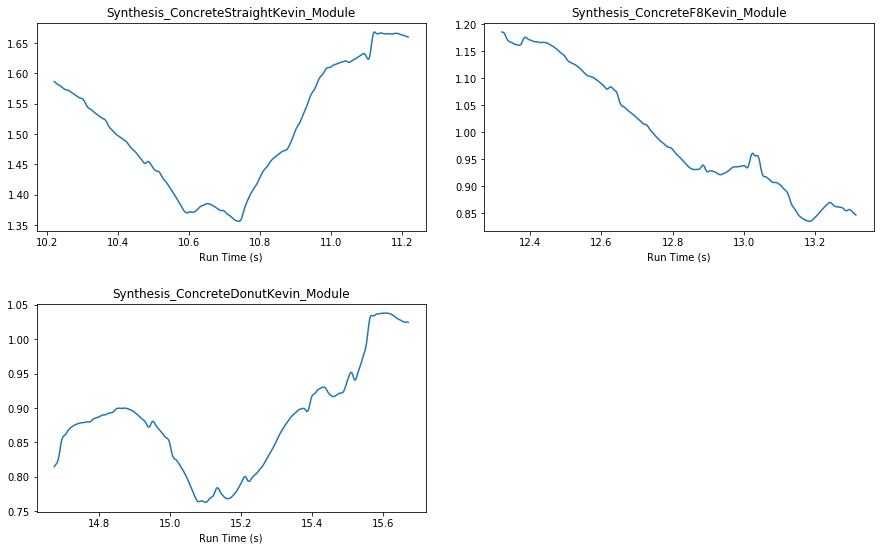

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Calc X Vel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [38]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [39]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 21
Num of FFT'd windows in first dataset: 70
Shape of FFT'd individual window: (64, 18)


,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Frequency
0,NaN,0.552875,0.015932,6.835093,3.540206,0.384467,9.968833,0.063198,0.090597,1.888195,8.081925,1.711513,0.763535,10.295430,0.004760,0.082493,1.796181,0.000000
1,NaN,0.125303,0.033224,2.178503,3.120365,0.207685,0.100348,0.035856,0.023384,0.403367,1.092563,3.568956,0.235967,0.190380,0.029067,0.047400,0.444002,1.000901
2,NaN,0.041857,0.006618,0.905922,1.204620,0.133320,0.059927,0.031595,0.015499,0.142658,0.103225,1.289658,0.064401,0.029323,0.024077,0.022182,0.122294,2.001802
3,NaN,0.027290,0.008518,0.724395,0.792478,0.045947,0.033679,0.006075,0.010376,0.090380,0.175930,1.056839,0.076659,0.110602,0.010297,0.010968,0.085111,3.002703
4,NaN,0.017566,0.025765,0.482797,0.355188,0.078889,0.109109,0.017594,0.008575,0.060748,0.086276,0.720588,0.082462,0.094683,0.013740,0.012648,0.041144,4.003604


<Figure size 432x288 with 0 Axes>

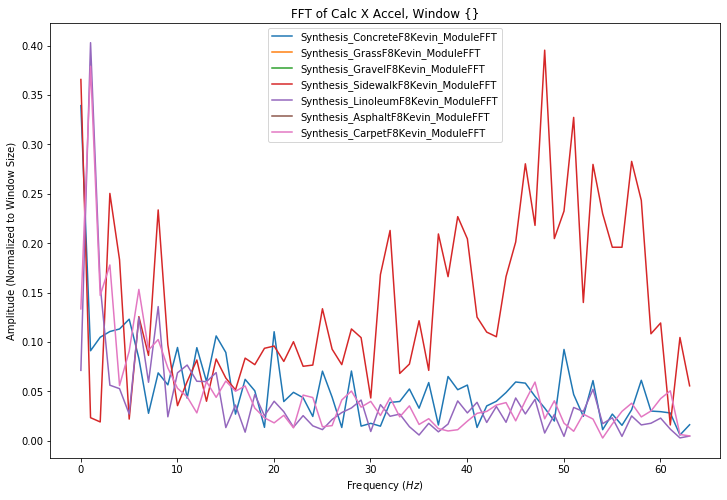

In [40]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

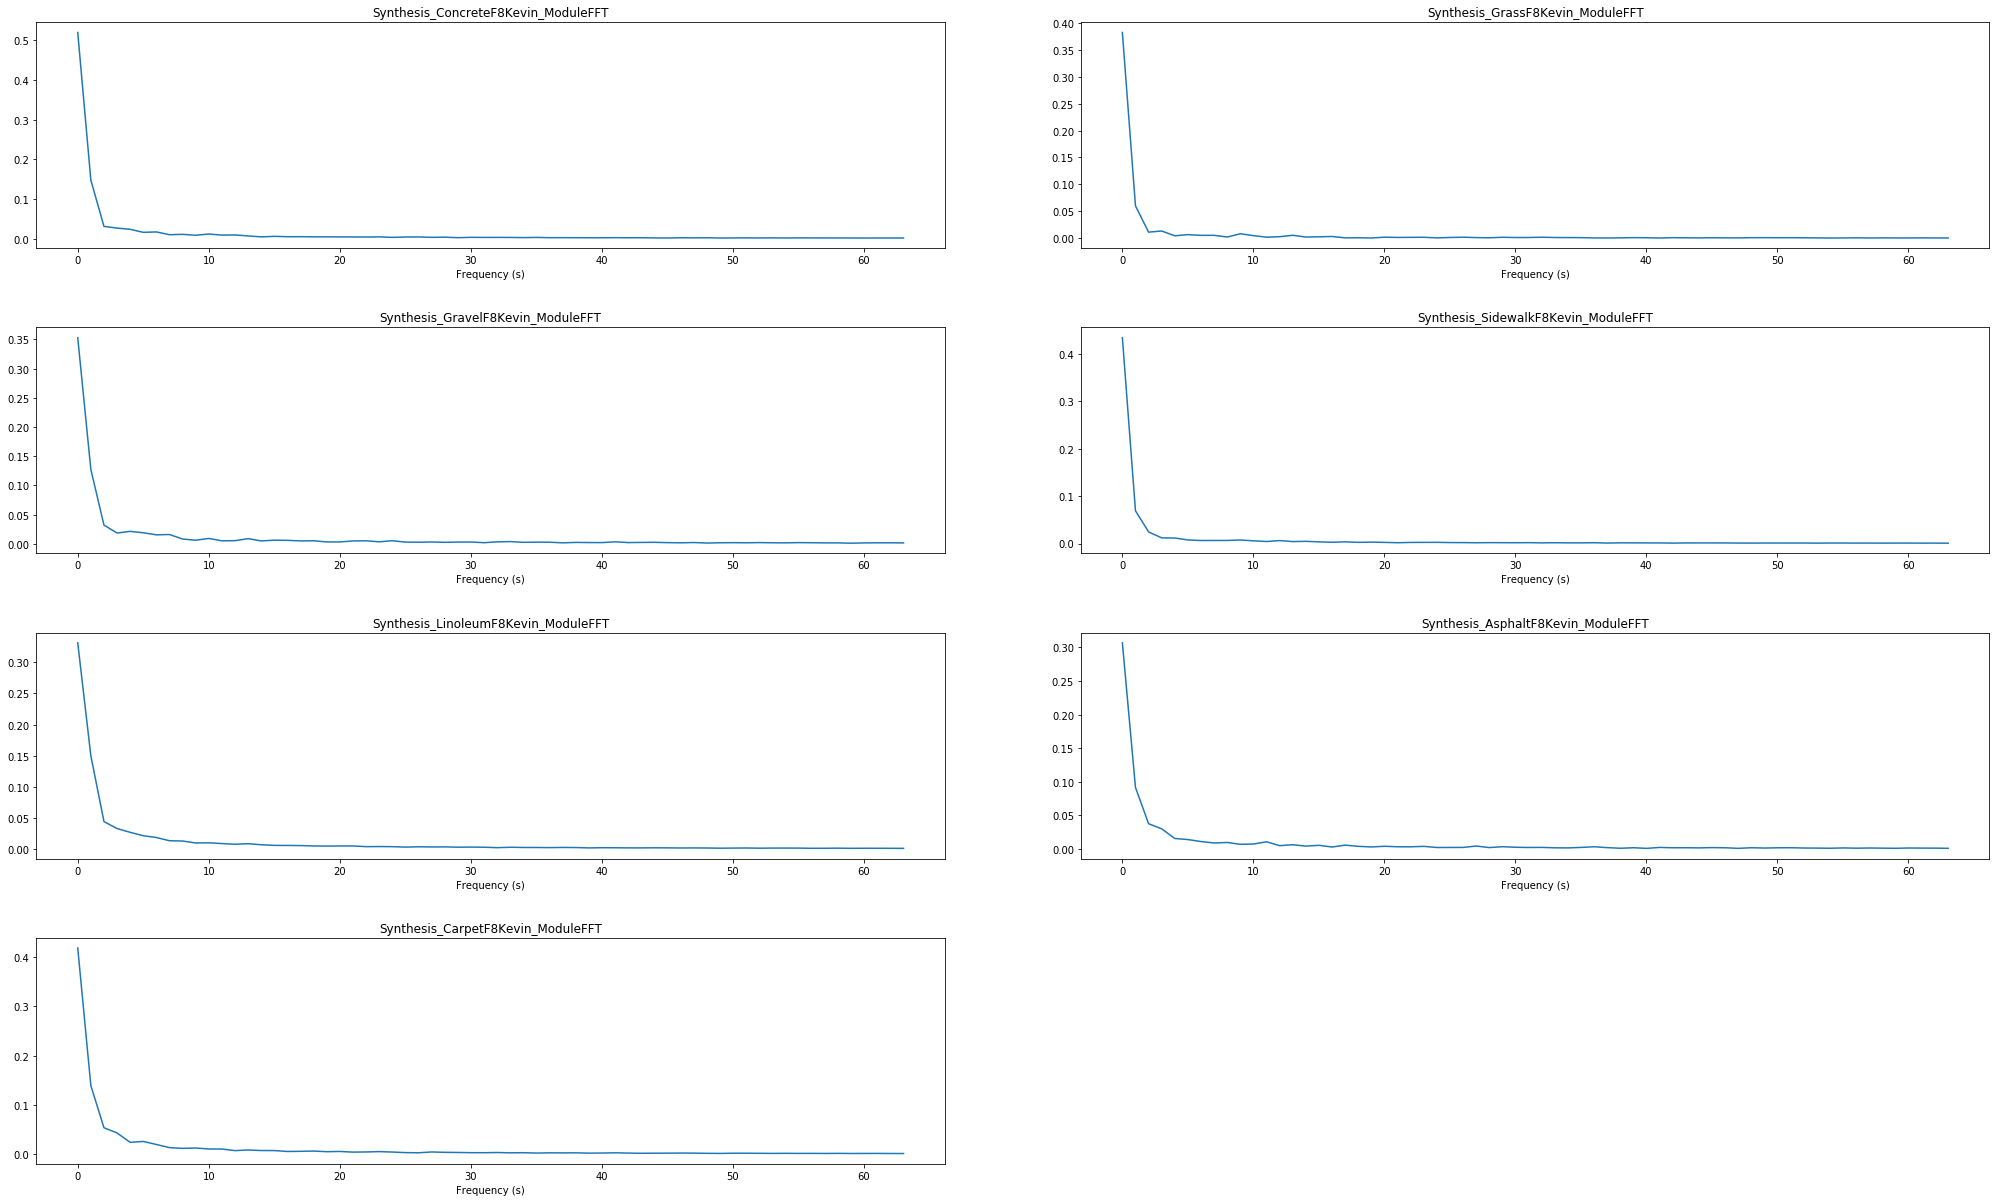

In [41]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Vel', windowed=True)

### Part (b) - PSD

In [42]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [43]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 21
Num of PSD'd windows in first dataset: 86
Shape of PSD'd individual window: (64, 18)


<Figure size 432x288 with 0 Axes>

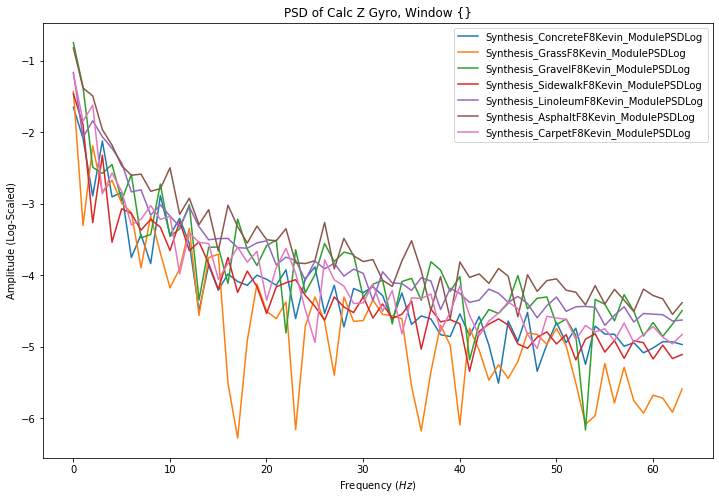

In [44]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

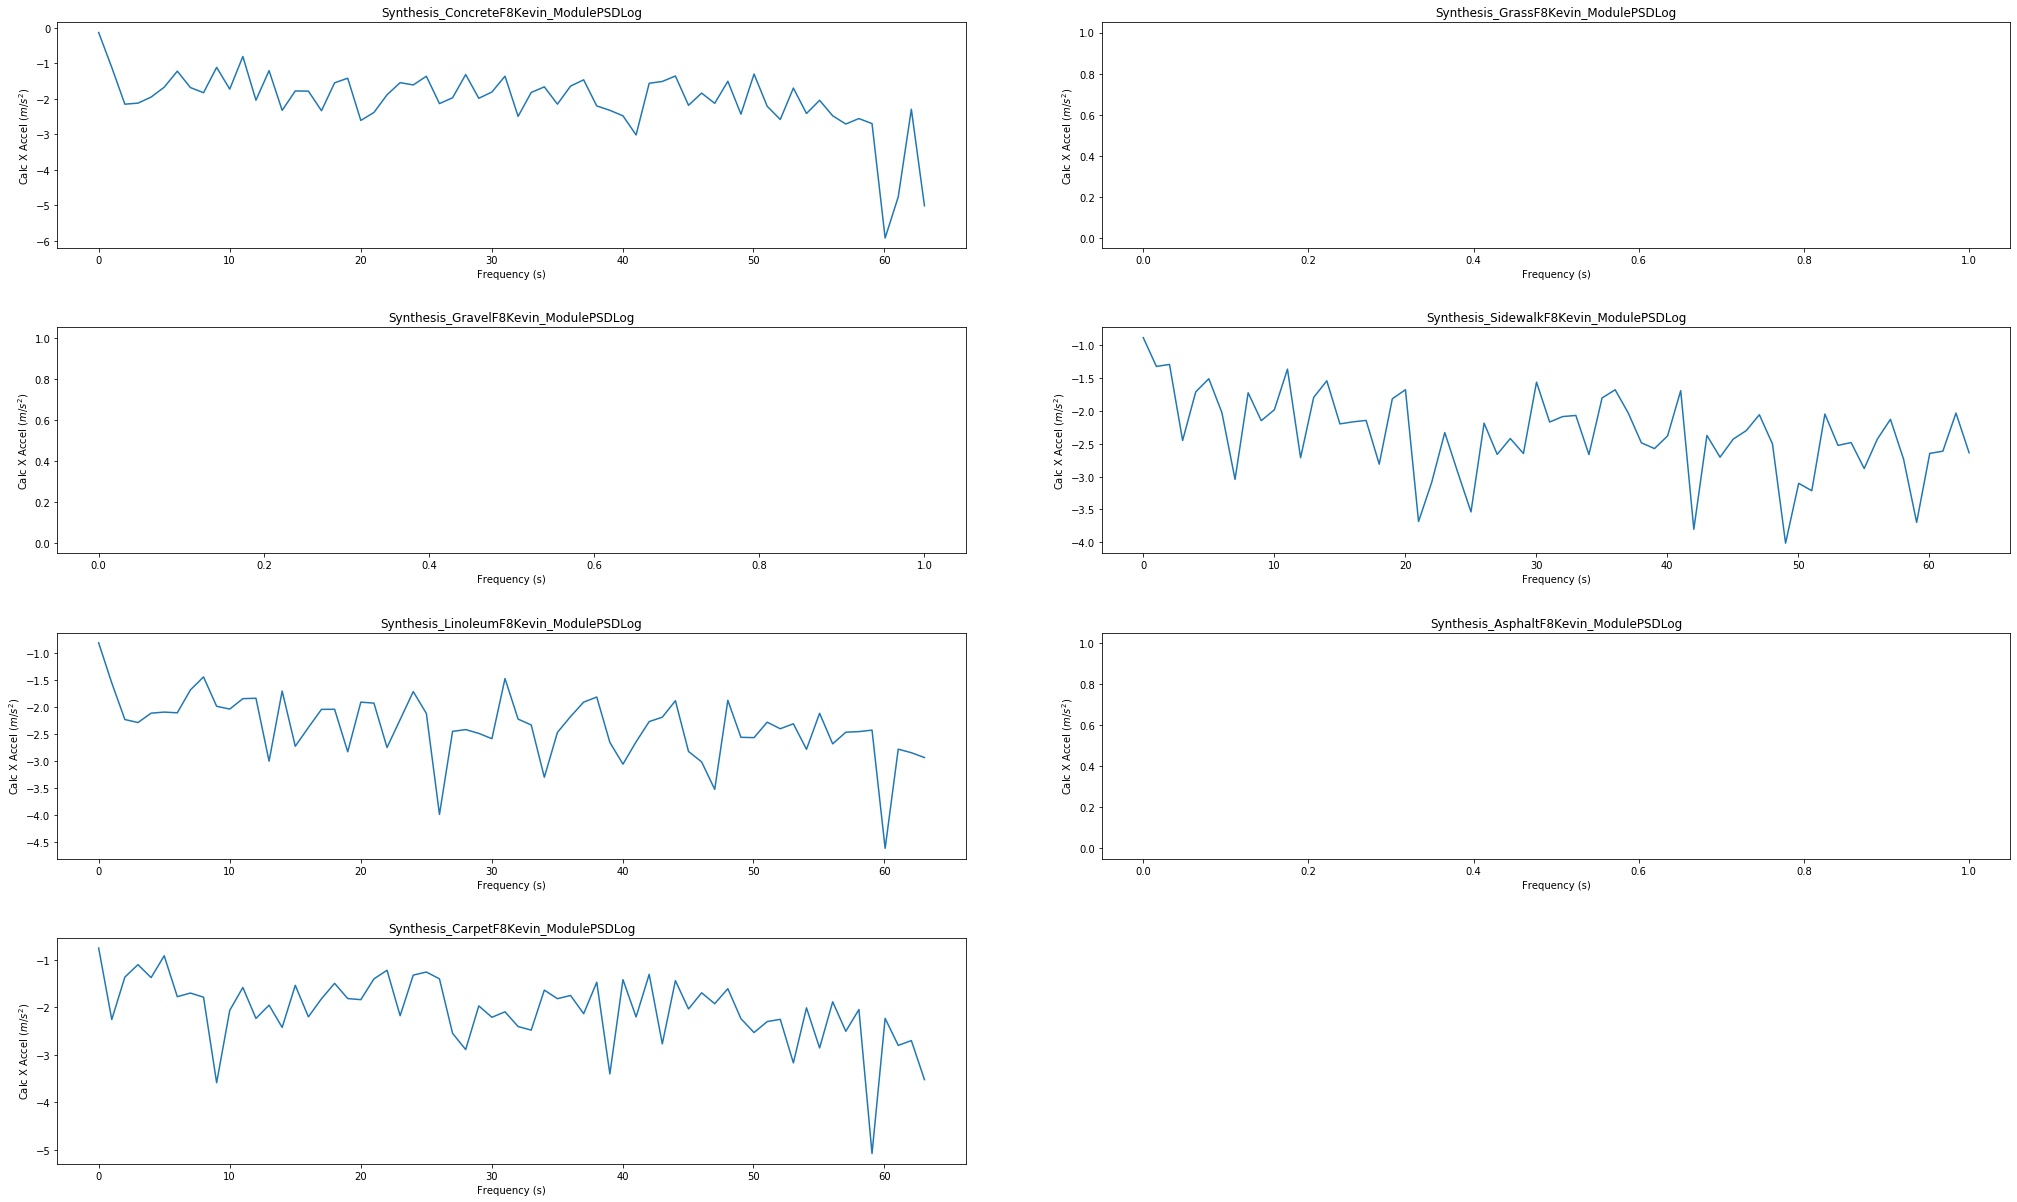

In [45]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [46]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

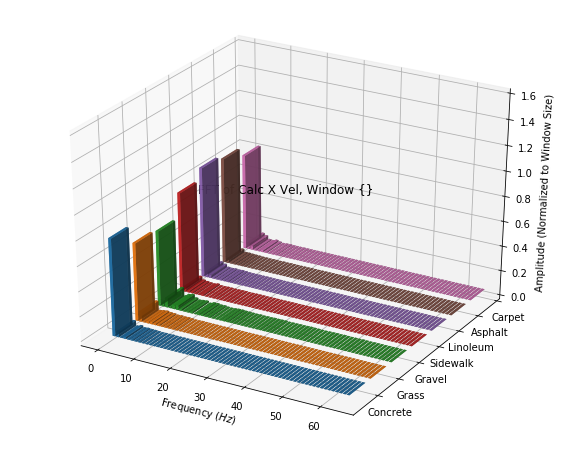

In [47]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

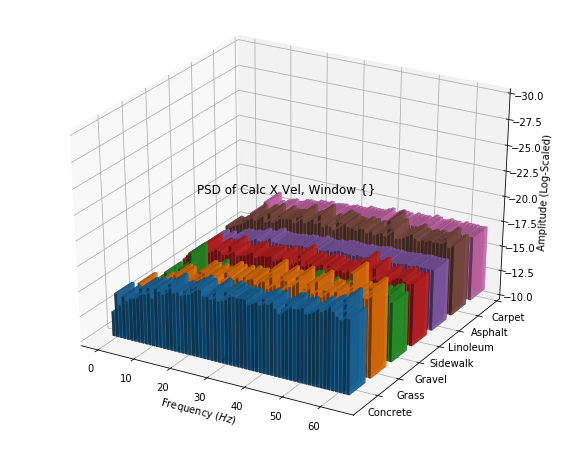

In [48]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [49]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

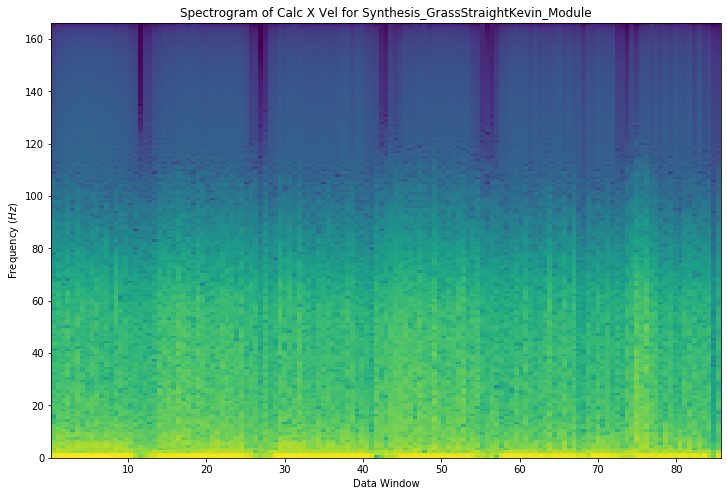

In [50]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [51]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [52]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [53]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [54]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [55]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['Calc X Accel'].shape))

Num datasets: 21
Num directions: 17
Shape of first dataset first direction: (86, 10)


<Figure size 432x288 with 0 Axes>

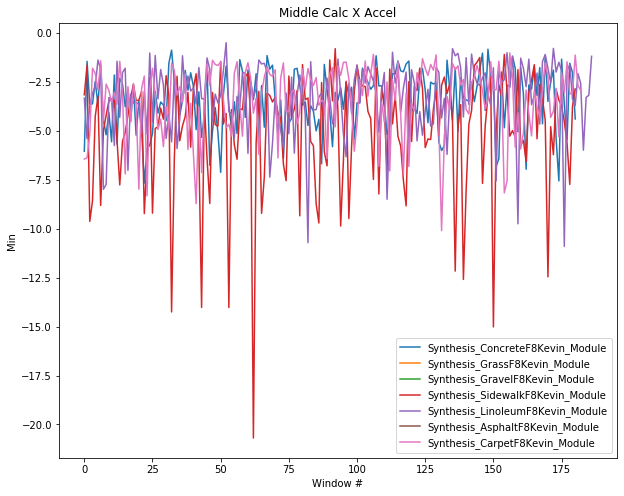

In [56]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Synthesis' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [57]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [58]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['Calc X Vel'].shape))

Num datasets: 21
Num directions: 17
Shape of one direction: (86, 5)


<Figure size 432x288 with 0 Axes>

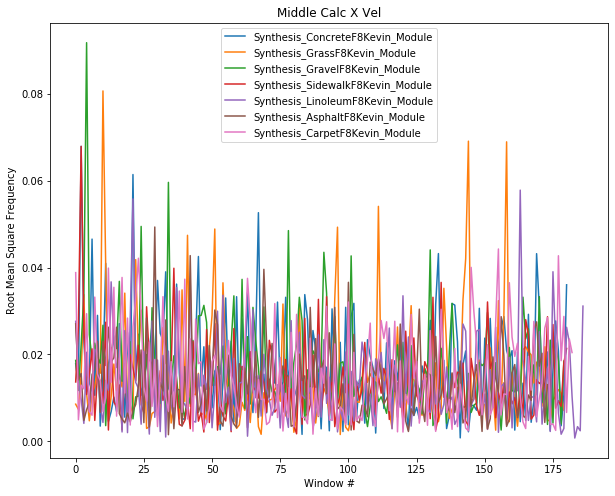

In [59]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [60]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [61]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [62]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [63]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [64]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [65]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [1]:
datasets_feat_norm[dataset_labels[0]]['Calc X Vel'].head()

NameError: name 'datasets_feat_norm' is not defined

<Figure size 432x288 with 0 Axes>

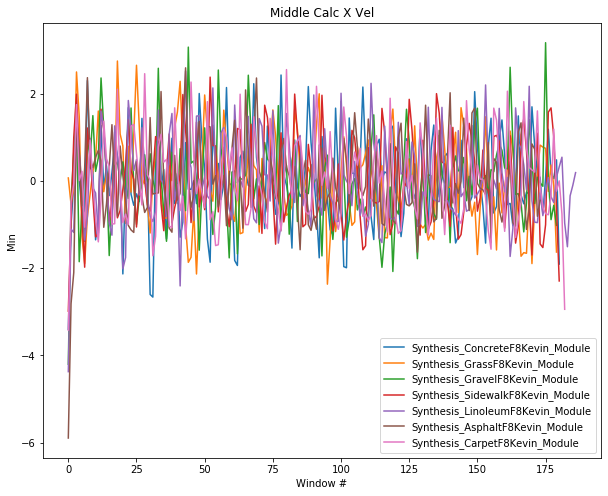

In [67]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Synthesis' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

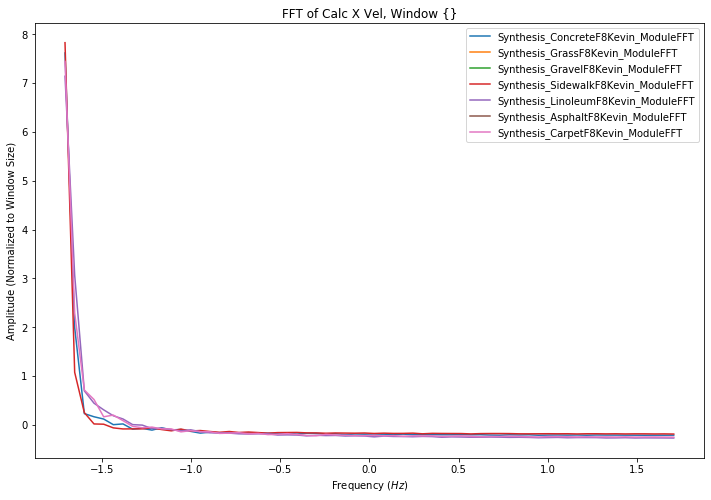

In [68]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [69]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [70]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [71]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,Excess Kurtosis Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.240447,-0.058440,-0.410659,1.083295,0.187070,-0.627680,-0.600479,-0.261413,0.482115,-0.600479
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.982256,1.077403,-0.410659,0.836321,0.632595,0.440087,0.750235,1.642741,-1.831694,0.750235
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.228029,1.783516,-0.410659,1.220025,1.381824,0.622197,0.900922,1.065665,-0.896313,0.900922
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.403665,2.077850,-0.410659,0.838869,0.613781,2.187034,1.920745,1.640705,-1.807706,1.920745
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.351176,2.135344,-0.410659,0.765411,0.497966,0.550898,0.843162,1.695481,-1.925596,0.843162


#### Part (ii) - Transformed Data

In [72]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [73]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [74]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [75]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,FFT 63.0 Hz Left X Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,0.004771,0.000735,0.000604,0.013347,0.036943,0.051358,0.014473,0.005461,0.000357,0.001149,...,1.888195,0.090597,0.063198,9.968833,0.384467,3.540206,6.835093,0.015932,0.552875,NaN
1,0.003632,0.000709,0.001366,0.014101,0.067265,0.035212,0.045118,0.000626,0.004371,0.006886,...,2.789078,0.080121,0.012134,10.374359,0.620894,0.631715,6.797707,0.039793,0.812432,NaN
2,0.000932,0.000192,0.001931,0.009319,0.031006,0.015430,0.048484,0.001014,0.002286,0.004086,...,3.105645,0.148097,0.055946,10.408546,0.117029,2.264206,5.985722,0.002394,0.916788,NaN
3,0.000627,0.000521,0.001555,0.009530,0.033487,0.026769,0.038393,0.000881,0.001058,0.003415,...,3.331579,0.176857,0.028672,10.527429,0.855447,0.909767,5.435776,0.007915,0.984874,NaN
4,0.002440,0.000196,0.002734,0.008982,0.033598,0.048639,0.036549,0.002520,0.000936,0.003394,...,3.387150,0.086189,0.035658,10.398862,0.603530,0.431985,5.584046,0.023396,1.005292,NaN
5,0.000884,0.000147,0.000369,0.018372,0.022262,0.056683,0.019878,0.001150,0.002724,0.002366,...,3.267019,0.119588,0.050980,10.376723,1.058731,1.748174,5.467767,0.021151,0.958271,NaN
6,0.000596,0.001008,0.002561,0.019238,0.023344,0.054546,0.030668,0.001240,0.001883,0.005407,...,3.134738,0.129399,0.058252,10.371625,0.920051,1.335355,5.629467,0.065272,0.907777,NaN
7,0.001062,0.000753,0.002013,0.014537,0.065684,0.045624,0.035501,0.000347,0.000832,0.003868,...,3.116772,0.108614,0.147101,10.279863,0.890619,2.487324,5.763783,0.065216,0.936404,NaN
8,0.001026,0.000479,0.001737,0.010675,0.052795,0.021875,0.019543,0.002336,0.004543,0.005370,...,2.608569,0.142993,0.150565,10.359893,0.755816,0.412825,6.974140,0.154926,0.729247,NaN
9,0.001000,0.001720,0.001578,0.027843,0.027827,0.011614,0.068010,0.001051,0.002216,0.005504,...,2.786127,0.094440,0.068273,10.162354,0.912434,1.755385,6.457310,0.033951,0.830735,NaN


In [76]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,PSD 63.0 Hz Left X Gyro Synthesis,...,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis,PSD 0.0 Hz Calc X Accel Synthesis
0,-4.368442,-6.060684,-6.343526,-4.385549,-3.592824,-2.362437,-3.903428,-4.269279,-7.144825,-5.879621,...,-0.487961,-2.961510,-2.590236,-1.696345,-1.064549,1.289050,0.976955,-2.656464,-1.503438,NaN
1,-4.548551,-6.228154,-4.839720,-2.748617,-2.681126,-3.416518,-2.324619,-4.744725,-4.660954,-4.654108,...,-1.840046,-3.472083,-2.249376,-0.922131,-1.454152,1.396243,0.902637,-2.110120,-2.479120,NaN
2,-5.897540,-6.975067,-6.321867,-3.323142,-3.586983,-2.850108,-2.604612,-6.141159,-5.416324,-4.762537,...,-2.463766,-2.974275,-2.930103,-1.876573,-0.748591,1.518414,1.040054,-1.904737,-3.754840,NaN
3,-5.869280,-5.860900,-6.786922,-3.136738,-3.358272,-2.788225,-2.258762,-6.091984,-6.522703,-4.856540,...,-1.754268,-2.926263,-2.765971,-0.823756,-1.680070,1.595808,1.013589,-2.288206,-3.338097,NaN
4,-4.933723,-6.082692,-5.042927,-3.591052,-3.840897,-2.237082,-2.884650,-4.842147,-4.538790,-5.177783,...,-1.611960,-2.684444,-2.235198,-1.211297,-0.897842,1.531171,1.171783,-1.842602,-3.644081,NaN
5,-5.982188,-6.023077,-5.457117,-4.329889,-2.234348,-2.138447,-3.095927,-7.014824,-6.468613,-4.823110,...,-1.554875,-2.249411,-2.557804,-2.091376,-0.666359,1.510380,1.173516,-2.377890,-2.885009,NaN
6,-5.950012,-6.698370,-4.819387,-3.574004,-2.851920,-2.173713,-3.023033,-5.572491,-4.754321,-4.868159,...,-1.470225,-2.587877,-3.231717,-0.895379,-0.711661,1.550242,1.113989,-2.564624,-2.672561,NaN
7,-5.624773,-5.716747,-5.676035,-4.295271,-2.438244,-2.661390,-3.506939,-5.490534,-5.456124,-4.752016,...,-1.626619,-2.603267,-2.075417,-1.020342,-0.697577,1.443598,1.135773,-1.689432,-3.172609,NaN
8,-5.467768,-5.221750,-4.433900,-4.311066,-2.758174,-2.629243,-2.117441,-5.473674,-5.300233,-3.960814,...,-0.987182,-2.048504,-2.150929,-1.793314,-1.005102,1.562755,0.449860,-2.177970,-2.227762,NaN
9,-5.634776,-5.615364,-6.069108,-3.399495,-2.837179,-5.133023,-2.137728,-5.393703,-5.066783,-4.268504,...,-1.472251,-3.172320,-2.339183,-1.336675,-1.032958,1.411161,0.982452,-2.199531,-2.912221,NaN


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [77]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [78]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [79]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.240447,-0.058440,-0.410659,1.083295,0.187070,-0.627680,-0.600479,-0.261413,0.482115,-0.600479
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.982256,1.077403,-0.410659,0.836321,0.632595,0.440087,0.750235,1.642741,-1.831694,0.750235
2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.228029,1.783516,-0.410659,1.220025,1.381824,0.622197,0.900922,1.065665,-0.896313,0.900922
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.403665,2.077850,-0.410659,0.838869,0.613781,2.187034,1.920745,1.640705,-1.807706,1.920745
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.351176,2.135344,-0.410659,0.765411,0.497966,0.550898,0.843162,1.695481,-1.925596,0.843162


In [80]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,5,0.004771,0.000735,0.000604,0.013347,0.036943,0.051358,0.014473,0.005461,0.000357,...,1.888195,0.090597,0.063198,9.968833,0.384467,3.540206,6.835093,0.015932,0.552875,NaN
1,5,0.003632,0.000709,0.001366,0.014101,0.067265,0.035212,0.045118,0.000626,0.004371,...,2.789078,0.080121,0.012134,10.374359,0.620894,0.631715,6.797707,0.039793,0.812432,NaN
2,5,0.000932,0.000192,0.001931,0.009319,0.031006,0.015430,0.048484,0.001014,0.002286,...,3.105645,0.148097,0.055946,10.408546,0.117029,2.264206,5.985722,0.002394,0.916788,NaN
3,5,0.000627,0.000521,0.001555,0.009530,0.033487,0.026769,0.038393,0.000881,0.001058,...,3.331579,0.176857,0.028672,10.527429,0.855447,0.909767,5.435776,0.007915,0.984874,NaN
4,5,0.002440,0.000196,0.002734,0.008982,0.033598,0.048639,0.036549,0.002520,0.000936,...,3.387150,0.086189,0.035658,10.398862,0.603530,0.431985,5.584046,0.023396,1.005292,NaN


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [81]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [82]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [83]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Kevin')

feat_combined['Synthesis'].tail()

,Label,Mean Calc X Vel Synthesis,Std Dev Calc X Vel Synthesis,L2 Norm Calc X Vel Synthesis,Autocorrelation Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,Root Mean Squared Calc X Vel Synthesis,Zero Crossing Rate Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
2224,1,0.680705,-0.694911,0.668161,0.649152,0.576506,0.754341,0.668161,-0.284089,-0.121491,...,-0.563920,0.712736,-0.496217,-0.660946,-0.596652,-0.586354,-1.019453,-1.063312,0.777640,-1.019453
2225,1,0.707846,-1.003351,0.693298,0.686127,0.416436,0.908825,0.693298,-0.284089,-0.822477,...,-0.357960,0.663096,-0.496217,1.530085,0.925263,-0.492274,-0.533580,-0.617258,0.626643,-0.533580
2226,1,0.406544,-0.282288,0.384848,0.252335,0.359474,0.352591,0.384848,-0.284089,-0.413602,...,-0.279594,0.380028,-0.496217,0.738159,-0.017228,-0.392045,-0.271276,1.076672,-0.880658,-0.271276
2227,1,-1.075232,0.804207,-1.101275,-1.229484,-0.909306,-1.007859,-1.101275,-0.284089,0.836916,...,0.802067,-1.262127,-0.496217,-1.226182,-0.622575,-0.172983,0.127919,0.628548,-0.334208,0.127919
2228,1,-2.233293,-0.775689,-2.330797,-1.693995,-2.877916,-1.577271,-2.330797,1.070798,2.435868,...,2.535926,-2.111464,1.701315,-1.597225,-0.039424,0.107662,0.504972,1.054973,-0.842627,0.504972


In [84]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Kevin')

fft_combined['Synthesis'].tail()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Right X Accel Synthesis,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis
2224,1,0.000745,0.000201,0.000416,0.022122,0.023497,0.027632,0.058341,0.000625,0.000977,...,0.566281,4.850009,0.172298,0.097743,10.005425,0.312199,3.793471,0.584730,0.068271,1.448503
2225,1,0.000267,0.000388,0.002054,0.003248,0.010676,0.060899,0.012761,0.001237,0.002030,...,3.603461,4.973757,0.280746,0.109492,10.204965,0.638215,2.244664,3.264382,0.021877,1.461570
2226,1,0.004339,0.000493,0.000357,0.010680,0.033013,0.005043,0.048715,0.004605,0.000460,...,1.845735,4.474961,0.246814,0.074799,9.821779,0.851095,1.678691,3.183403,0.013880,1.316505
2227,1,0.006939,0.000323,0.000451,0.008573,0.012188,0.010454,0.046894,0.007158,0.000399,...,3.458900,1.996922,0.083090,0.004338,9.368597,0.295330,4.943301,6.144677,0.053811,0.603083
2228,1,0.007081,0.005354,0.002634,0.006282,0.003970,0.013847,0.014526,0.002336,0.004762,...,8.081339,0.943281,0.518141,0.734474,9.080306,1.056117,4.029940,7.841895,0.895193,0.045518


In [85]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Kevin')

psd_log_combined['Synthesis'].tail()

,Label,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,...,PSD 0.0 Hz Right X Accel Synthesis,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis
2224,1,-5.648874,-6.464451,-6.229163,-3.066448,-2.620642,-3.824506,-2.131277,-6.043420,-6.303538,...,1.701025,-1.018966,-2.253721,-2.500652,-0.276134,-0.765781,1.478801,1.661818,-2.152839,-2.089894
2225,1,-6.654995,-5.946113,-5.310464,-3.073265,-3.086967,-2.713242,-3.892593,-5.587419,-5.279736,...,1.518741,-1.252749,-2.889417,-2.991670,-0.312262,-0.935583,1.635301,1.569777,-1.920017,-2.547623
2226,1,-4.458282,-6.043045,-6.295671,-4.379052,-2.443783,-3.551904,-2.273783,-4.402286,-6.442450,...,1.698261,-0.990885,-2.792222,-4.104600,-0.214481,-1.325143,1.543692,1.596418,-2.489150,-1.953837
2227,1,-4.045615,-6.743380,-6.592699,-3.756642,-4.018232,-3.606406,-2.380968,-4.008980,-6.514019,...,1.137155,-0.311257,-2.781212,-3.326832,-0.748751,-1.958899,0.948800,0.833186,-2.563461,-1.358906
2228,1,-4.013455,-4.253101,-4.846637,-4.800249,-4.855998,-3.295729,-3.589299,-4.946026,-4.356087,...,0.050662,-1.292581,-0.847365,-0.941119,-2.242064,-1.014805,0.429735,-0.165333,-0.719559,-2.398967


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right